In [1]:
%config IPCompleter.greedy=True

In [2]:
import random
import gym
import numpy as np
import time 
from gym.envs.registration import register
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
        ) 

# env_name = "CartPole-v1"
# env_name = "MountainCar-v0"
# env_name = "MountainCarContinuous-v0"
# env_name = "Acrobot-v1"
# env_name = "Pendulum-v1"
# env_name = "FrozenLake-v1"
env_name = "FrozenLakeNoSlip-v0"

In [4]:
env = gym.make(env_name)

print("Observation space ->", env.observation_space)
print("Action space ->", env.action_space)
print("Type of action ->", type(env.action_space))

Observation space -> Discrete(16)
Action space -> Discrete(4)
Type of action -> <class 'gym.spaces.discrete.Discrete'>


In [5]:
class Agent:
    '''
    1. Model이 discrete한지 continuous한지 판단하고, state_size를 저장한다.
    2. discrete일 경우, action_size를 저장. 
    3. continuous일 경우, action의 boundary와 shape을 저장.
    '''
    def __init__(self, env):
        self.is_discrete = \
            type(env.action_space) == gym.spaces.discrete.Discrete
        
        # state_size == state의 갯수 
        self.state_size = env.observation_space.n
        print("State size:", self.state_size)
        
        if self.is_discrete:
            # action_size == action의 갯수 
            self.action_size = env.action_space.n
            print("Environment is Discrete and Action size is", self.action_size)
  
        else:
            print("Environment is Continuous")
            
            # action의 boundary와 action의 shape
            self.action_low = env.action_space.low 
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("self.action_low ->", self.action_low)
            print("self.action_high ->", self.action_high)
            print("self.action_shape ->", self.action_shape)

    def get_action(self, state):
        '''
        Returns a randomly selected action
        '''
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low,
                                       self.action_high,
                                       self.action_shape)
            
        return action

In [6]:
class SARSA_Agent(Agent):
    def __init__(self, env, discount_rate=0.97, learning_rate=0.01):
        super().__init__(env)
        
        self.eps = 1.0
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
        
        print("discount_rate:", discount_rate)
        print("learning_rate:", learning_rate)
        
    def build_model(self):
        self.SARSA_table = 1e-4*np.random.random([self.state_size, self.action_size])
        
    def get_action(self, state):
        SARSA_current = self.SARSA_table[state]
        action_greedy = np.argmax(SARSA_current)
        action_random = super().get_action(state)
        
        # Decaying epsilon algorithm. Decay a chance of having the random action for every episode.
        if random.random() < self.eps:
            return action_random 
        else:
            return action_greedy
    
    def train(self, experience):
        state, action, reward, next_state, next_action, done = experience
        
        SARSA_next = self.SARSA_table[next_state]
        
        if done:
            SARSA_next = np.zeros([self.action_size])

        self.SARSA_table[state, action] = (1 - self.learning_rate) * self.SARSA_table[state, action] + \
        self.learning_rate * (reward + self.discount_rate * self.SARSA_table[next_state, next_action])
        
        if done:
            # decay epsilon. 
            self.eps = self.eps * 0.99 

In [7]:
# Generate an agent that follows SARSA-Learning algorithm.
SARSA_agent = SARSA_Agent(env)
total_reward = 0
total_reward_list = list()
episodes = 1000

for episode in range(episodes):
    
    total_reward_list.append(total_reward)
    state = env.reset() # reset the environment when the episode terminates
    
    print(f"Entering Episode {episode}")
    print(f"Total Reward is {total_reward}")
#     time.sleep(0.25)
    
    done = False
    
    SARSA_action = SARSA_agent.get_action(state)
    
    while not done:

        next_state, reward, done, info = env.step(SARSA_action)
        
        SARSA_next_action = SARSA_agent.get_action(next_state)
        
        # save the agent's experience as a tuple
        experience = (state, SARSA_action, reward, next_state, SARSA_next_action, done)
        print(f"S:{state} -> A:{SARSA_action} -> R:{reward} -> S:{next_state} -> A:{SARSA_next_action}. Done? {done}")

        # train my SARSA_agent
        SARSA_agent.train(experience)
        
        # The agent moves to the next state
        state = next_state
        
        SARSA_action = SARSA_next_action
        
        # accumulate reward
        total_reward = total_reward + reward
        
        print(f"Episode: {episode}, Total reward: {total_reward}, eps: {SARSA_agent.eps}")
        print("---------------------------------------------------------------------")
        print(f"<SARSA table>\n", SARSA_agent.SARSA_table)
        print("---------------------------------------------------------------------")
        
        env.render()
        clear_output(wait=True)
        
#         time.sleep(0.25)

S:1 -> A:1 -> R:0.0 -> S:5 -> A:2. Done? True
Episode: 999, Total reward: 4.0, eps: 4.317124741065784e-05
---------------------------------------------------------------------
<SARSA table>
 [[5.73958225e-05 4.15122495e-05 7.19714329e-05 4.73513648e-05]
 [5.35622911e-05 7.42169489e-05 7.31219995e-05 7.31178370e-05]
 [7.43081271e-05 3.69992296e-05 1.49089330e-05 8.82296675e-06]
 [9.33140976e-05 9.33499702e-05 6.26955125e-05 4.06926195e-05]
 [5.98733605e-05 7.75799980e-05 7.46553294e-05 6.28469851e-05]
 [7.17901242e-05 4.91919093e-05 7.65169270e-05 3.98873360e-05]
 [2.40631363e-05 1.27293482e-05 9.12048003e-05 8.71494047e-05]
 [9.01111528e-05 6.61716956e-05 1.44486585e-05 2.14635580e-05]
 [1.22380949e-05 9.11451934e-05 1.21498944e-05 1.31297842e-05]
 [3.26777147e-05 8.75380235e-05 8.79034156e-06 7.43527467e-05]
 [9.31171371e-05 4.10898925e-05 4.71742224e-06 5.16414550e-05]
 [6.51605191e-05 7.34293728e-06 8.89673462e-05 7.80293435e-05]
 [2.04249425e-05 8.70220657e-05 2.11084054e-05 4.5865

In [8]:
def analysis_tool(episode_length, total_reward):
    fig, ax = plt.subplots()
    x = np.linspace(0, episode_length, num=episode_length)
    y = total_reward 
    
    ax.plot(x, y)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Total Reward')
    
    ax.set_ylim(0, episode_length)
    ax.set_title('Accumulated Total Rewards')
    ax.grid()

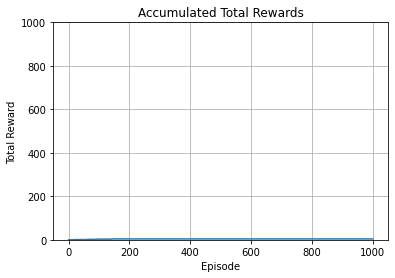

In [9]:
analysis_tool(episodes, total_reward_list)